<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_8_Theoretical_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

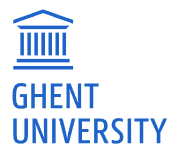<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 8 - A Theoretical Case Study**

This notebook contains code examples illustrating the large time approximation of transient flow to a pumping well in a confined multilayer aquifer system. The explanation provided with each example is relatively concise. To gain a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a detailed explanation including the mathematical proof, I refer to chapter 9 of [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

The examples will show that drawdown at large values of time due to pumping in a confined multilayer aquifer system can be approximated as follows:

> $s_{trans} \approx s_{steady} - s_{thiem} + s_{theis}$

The approximation becomes valid when time

> $t > 10 Sc$

and for distances

> $r > 8L_m$

where $S$ is the sum of all storativities, $c$ the sum of all resistances, and $L_m$ the largest leakage factor.

To illustrate the approximation is valid indeed for large values of time, we need to simulate the drawdown using:
- a transient-state multilayer model
- a steady-state multilayer model
- a steady-state Thiem model
- a transient-state Theis model

where input parameters of the 1D models are the sum of the input parameters of the multilayer models.

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 167 (delta 45), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (167/167), 6.98 MiB | 9.99 MiB/s, done.
Resolving deltas: 100% (79/79), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023).

We will also use the [TimML](https://timml.readthedocs.io/en/latest) and [TTim](https://ttim.readthedocs.io/en/latest) packages:

In [3]:
!pip install timml ttim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00


In [4]:
import timml, ttim

## 1. A first example

Let's import classes `Transient` and `Steady` and functions `thiem` and `theis` first:

In [5]:
from maxsypy.multilayer import Transient, Steady
from maxsypy.special import thiem, theis

Now consider the following confined two-layer system:

In [6]:
T = np.array([50, 100])
S = np.array([0.025, 0.1])
c = 100
Q = np.array([0, 150])

Let's simulate drawdown using the different models:

In [7]:
r = np.logspace(-1, 9, 100)   # radial distance (m)
t = np.logspace(-4, 10, 100)  # simulation times (d)
R = 1e5                       # radius (m) of the outer boundary of the steady-state models

transient = Transient(T=T, S=S, Q=Q, c=c)  # transient-state multilayer model
steady = Steady(T=T, Q=Q, c=c, r_out=R)    # steady-state multilayer model

s_trans = transient.h(r=r, t=t)  # transient-state drawdown (m)
s_steady = steady.h(r=r)         # steady-state drawdown (m)
s_thiem = thiem(r=r, T=T.sum(), Q=Q.sum(), r_out=R)         # drawdown (m) according to Thiem
s_theis = theis(r=r, t=t, T=T.sum(), S=S.sum(), Q=Q.sum())  # drawdown (m) according to Theis

Checking the shape of the drawdown arrays:

In [8]:
print(s_trans.shape)
print(s_steady.shape)
print(s_thiem.shape)
print(s_theis.shape)

(2, 100, 100)
(2, 100)
(100,)
(100, 100)


Plotting the time-drawdown graph:

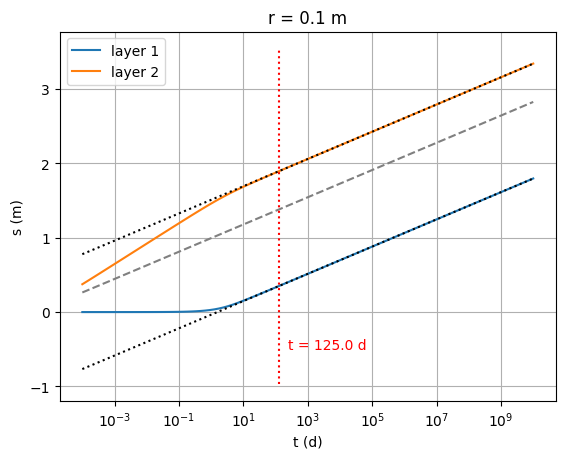

In [9]:
s_exact = s_trans[:, 0, :].squeeze().T  # exact drawdown
s_approx = s_steady[:, [0]].T - s_thiem[0] + s_theis[[0], :].T  # approximate drawdown
t_approx = 10 * S.sum() * c  # time from which the approximation becomes valid

plt.semilogx(t, s_exact);  # exact solution
plt.semilogx(t, s_approx, 'k:');  # approximate solution
plt.semilogx(t, s_theis[0, :], linestyle='--', color='gray');  # Theis solution
plt.semilogx([t_approx, t_approx], plt.ylim(), 'r:');  # approximation time
plt.text(t_approx*2, -0.5, f't = {t_approx} d', color='red');

plt.legend([f'layer {i+1}' for i in range(transient.nl)]);
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.title(f'r = {r[0]} m');

And finally plotting the distance-drawdown graph:

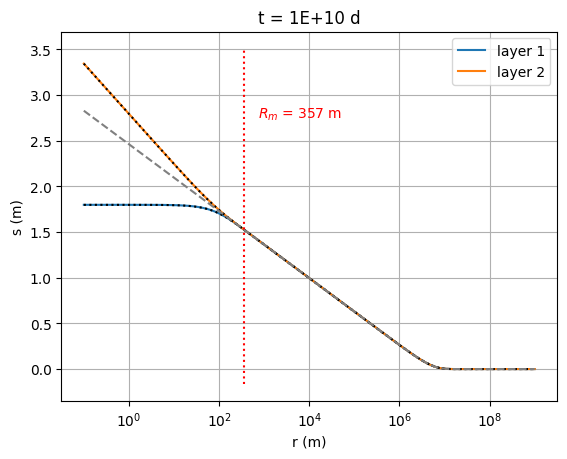

In [10]:
s_exact = s_trans[:, :, -1].T  # exact drawdown
s_approx = s_steady.T - s_thiem[:, np.newaxis] + s_theis[:, [-1]]  # approximate drawdown
Rm = 357  # distance from which the approximation becomes valid, determined from the eigenvalues

plt.semilogx(r, s_exact);  # exact solution
plt.semilogx(r, s_approx, 'k:');  # approximate solution
plt.semilogx(r, s_theis[:, -1], linestyle='--', color='gray');  # Theis solution
plt.semilogx([Rm, Rm], plt.ylim(), 'r:');  # approximation distance
plt.text(Rm*2, 2.75, f'$R_m$ = {Rm} m', color='red');

plt.legend([f'layer {i+1}' for i in range(transient.nl)]);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.title(f't = {t[-1]:.0E} d');

## 2. A second example

Consider the following confined multilayer system extracted by a multi-level pumping well:

In [11]:
T = np.arange(1, 6) * 100            # aquifer transmissivities (m²/d)
S = 1 / np.logspace(1, 5, 5)         # aquifer storativities (-)
c = np.arange(1, 5) * 1000           # resistance (d) of the separating aquitards
Q = np.array([50, 0, 100, 0, 200])   # well discharge (m³/d) in each aquifer

print(f'T = {T}')
print(f'S = {S}')
print(f'c = {c}')
print(f'Q = {Q}')

T = [100 200 300 400 500]
S = [1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]
c = [1000 2000 3000 4000]
Q = [ 50   0 100   0 200]


Simulating drawdown using the different models:

In [12]:
r = 0.1                      # radial distance (m)
t = np.logspace(-5, 5, 100)  # simulation times (d)
R = 1e5                      # radius (m) of the outer boundary of the steady-state models

transient = Transient(T=T, S=S, Q=Q, c=c)  # transient-state multilayer model
steady = Steady(T=T, Q=Q, c=c, r_out=R)    # steady-state multilayer model

s_trans = transient.h(r=r, t=t).squeeze().T  # transient-state drawdown (m)
s_steady = steady.h(r=r).T                   # steady-state drawdown (m)
s_thiem = thiem(r=r, T=T.sum(), Q=Q.sum(), r_out=R).squeeze()  # drawdown (m) according to Thiem
s_theis = theis(r=r, t=t, T=T.sum(), S=S.sum(), Q=Q.sum()).T   # drawdown (m) according to Theis

Plotting the result:

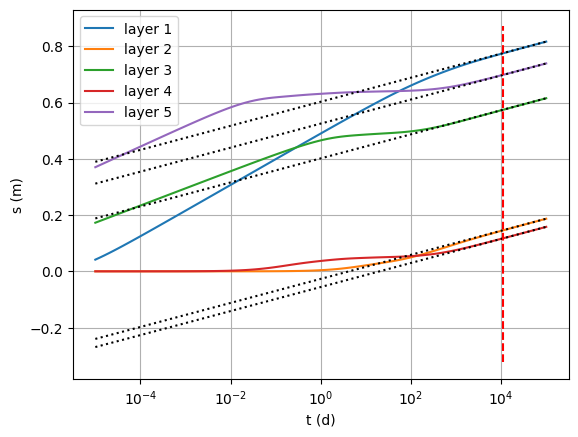

In [13]:
plt.semilogx(t, s_trans);  # exact drawdown
plt.semilogx(t, s_steady - s_thiem + s_theis, 'k:');  # approximate drawdown

t_approx = 10 * S.sum() * c.sum()  # time from which the approximation becomes valid
plt.semilogx([t_approx, t_approx], plt.ylim(), 'r--');

plt.legend([f'layer {i+1}' for i in range(transient.nl)]);
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');

We observe that the approximate solution indeed coincides with the exact solution after more than 10000 days of pumping!

## 3. TTim and TimML



Of course, it is also possible to simulate these examples using the TTim and TimML packages. Let's do that for the second example. Here, we also need to set up a transient-state model, the corresponding steady-state multilayer model, and the Thiem and Theis model with the sum of the input parameters.

First, we simulate drawdown using a TTim transient-state multilayer model:

In [14]:
z = np.ones(10).cumsum()[::-1]
trans = ttim.ModelMaq(z=z, kaq=T, Saq=S, c=c, tmin=t[0], tmax=t[-1])
for i, Qw in enumerate(Q):
    if Qw > 0:
        ttim.Well(trans, tsandQ=[(0, -Qw)], layers=i)
trans.solve()
s_trans = trans.head(0, r, t)

self.neq  3
solution complete


Now, we simulate the corresponding TimML multilayer model:

In [15]:
steady = timml.ModelMaq(z=z, kaq=T, c=c)
timml.Constant(steady, 0, R)
for i, Qw in enumerate(Q):
    if Qw > 0:
        timml.Well(steady, Qw=-Qw, layers=i)
steady.solve()
s_steady = steady.head(0, r)

Number of elements, Number of equations: 4 , 1
....
solution complete


The equivalent Thiem model is also simulated using TimML:

In [16]:
thm = timml.ModelMaq(z=[1, 0], kaq=T.sum())
timml.Constant(thm, 0, R)
timml.Well(thm, Qw=-Q.sum())
thm.solve()
s_thiem = thm.head(0, r)

Number of elements, Number of equations: 2 , 1
..
solution complete


Finally, we simulate drawdown for the comprehensive Theis model using TTim:

In [17]:
ths = ttim.ModelMaq(z=[1, 0], kaq=T.sum(), Saq=S.sum(),
                    tmin=t[0], tmax=t[-1])
ttim.Well(ths, tsandQ=[(0, -Q.sum())])
ths.solve()
s_theis = ths.head(0, r, t)

self.neq  1
solution complete


Checking the shape of the drawdown arrays:

In [18]:
print(s_trans.shape)
print(s_steady.shape)
print(s_thiem.shape)
print(s_theis.shape)

(5, 100)
(5,)
(1,)
(1, 100)


Plotting the result:

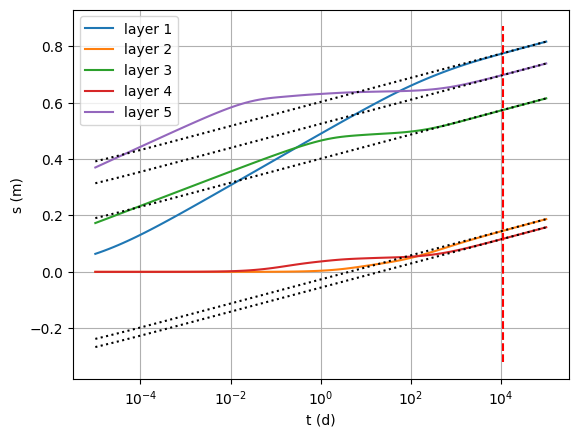

In [19]:
plt.semilogx(t, s_trans.T);  # exact solution
plt.semilogx(t, s_steady[:, np.newaxis].T - s_thiem + s_theis.T, 'k:');  # approximate solution

t_approx = 10 * S.sum() * c.sum()  # time from which the approximation becomes valid
plt.semilogx([t_approx, t_approx], plt.ylim(), 'r--');

plt.legend([f'layer {i+1}' for i in range(transient.nl)]);
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');

We indeed get the same graph!

---